In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchinfo import summary
from scipy.io import loadmat
from tqdm.auto import tqdm
import torchvision.transforms as transforms
from torchvision.models import resnet50
import torch.nn.functional as F
from sklearn.utils import shuffle
import time

In [ ]:
# Use the best pre-train model in our few shot learning: Resnet model
module = resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.6MB/s]


In [ ]:
# This part checks the device currently used
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Preparation**

In [ ]:
# Import downloaded dataset from OneDrive
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/CZ4042_group_proj/dataset.zip'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: dataset/flowers-102/jpg/image_03191.jpg  
  inflating: dataset/flowers-102/jpg/image_03192.jpg  
  inflating: dataset/flowers-102/jpg/image_03193.jpg  
  inflating: dataset/flowers-102/jpg/image_03194.jpg  
  inflating: dataset/flowers-102/jpg/image_03195.jpg  
  inflating: dataset/flowers-102/jpg/image_03196.jpg  
  inflating: dataset/flowers-102/jpg/image_03197.jpg  
  inflating: dataset/flowers-102/jpg/image_03198.jpg  
  inflating: dataset/flowers-102/jpg/image_03199.jpg  
  inflating: dataset/flowers-102/jpg/image_03200.jpg  
  inflating: dataset/flowers-102/jpg/image_03201.jpg  
  inflating: dataset/flowers-102/jpg/image_03202.jpg  
  inflating: dataset/flowers-102/jpg/image_03203.jpg  
  inflating: dataset/flowers-102/jpg/image_03204.jpg  
  inflating: dataset/flowers-102/jpg/image_03205.jpg  
  inflating: dataset/flowers-102/jpg/image_03206.jpg  
  inflating: dataset/flowers-102/jpg/image_03207.jpg  
  inflating: dataset/flowers-102/jpg/i

In [ ]:
setid = loadmat('./dataset/flowers-102/setid.mat')
setid

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

In [ ]:
idx_train = setid['trnid'][0] - 1
idx_test = setid['tstid'][0] - 1
idx_valid = setid['valid'][0] - 1

In [ ]:
image_labels = loadmat('./dataset/flowers-102/imagelabels.mat')['labels'][0]
image_labels -= 1
image_labels

array([76, 76, 76, ..., 61, 61, 61], dtype=uint8)

In [ ]:
import glob
files = sorted(glob.glob('./dataset/flowers-102/jpg/*.jpg'))
len(files)
labels = np.array(list(zip(files, image_labels)))

In [ ]:
#write the splitted data file names into txt files for DataLoader to load data
def write_set_file(fout, labels):
    with open(fout, 'w+') as f:
        for label in labels:
            f.write('%s %s\n' % (label[0], label[1]))

# Images are ordered by species, so shuffle them
np.random.seed(42)
idx_train = idx_train[np.random.permutation(len(idx_train))]
idx_test = idx_test[np.random.permutation(len(idx_test))]
idx_valid = idx_valid[np.random.permutation(len(idx_valid))]

write_set_file('train.txt', labels[idx_train,:])
write_set_file('test.txt', labels[idx_test,:])
write_set_file('valid.txt', labels[idx_valid,:])

# **Customize Data Loader**

Put images from the same label together and generate sample batch for training the model

In [ ]:
class SiameseLoader:
    def __init__(self, txt_file):
      self.w = 224
      self.h = 224
      self.c = 3

      # Loading either the training or validation datasets
      self.transform = transforms.Compose([transforms.Resize((self.w, self.h)),
                                        transforms.ToTensor()])

      # Load data from splitted txt files
      self.txt_file = txt_file
      self.data=self.read_from_txt_file()
      self.labels = []

    def __len__(self):
      return len(self.data)

    def read_from_txt_file(self):
      data = {}
      f = open(self.txt_file)

      # Load data in the form data[label].append(image_data), This is for few shot learning to put same labeled images into one set
      for line in f.readlines():
        image_file, label = line.split()
        label = int(label)
        if label not in data:
          data[label] = []
        image = self.transform(Image.open(image_file))
        data[label].append(image)

      return data

    def getBatch(self, batch_size):
      '''
       The getBatch method aims to generate training batch depends on batch size,
       it returns data pair with two images data, half of batch size is in the
       same class and half is in the different class, totally there are only batch
       size classes being used.
      '''
      self.labels = list(self.data.keys())
      flowers = random.sample(self.labels, k=batch_size)
      left = [torch.zeros((self.c, self.h, self.w)) for _ in range(batch_size)]
      right = [torch.zeros((self.c, self.h, self.w)) for _ in range(batch_size)]
      targets = torch.zeros((batch_size,))

      # Get the target into two parts
      targets[batch_size // 2:] = 1

      for idx in range(batch_size):
        category = flowers[idx]

        left[idx] = torch.tensor(random.sample(self.data[category], k=1)[0])

        # For the first half batch we put different class image pair
        if idx < batch_size // 2:
          new_idx = (idx + random.randint(1, len(flowers))) % len(flowers)
          category = flowers[new_idx]

          right[idx] = torch.tensor(random.sample(self.data[category], k=1)[0])

      inputs = [torch.stack(left), torch.stack(right)]
      return inputs, targets

    def generate(self, batch_size):
      while True:
        inputs, targets = self.getBatch(batch_size)
        yield (inputs, targets)

Load train data from prepared dataset

In [ ]:
train_loader = SiameseLoader('./train.txt')
print(len(train_loader.data.keys()))

102


Plot some images to check if the data loader works properly

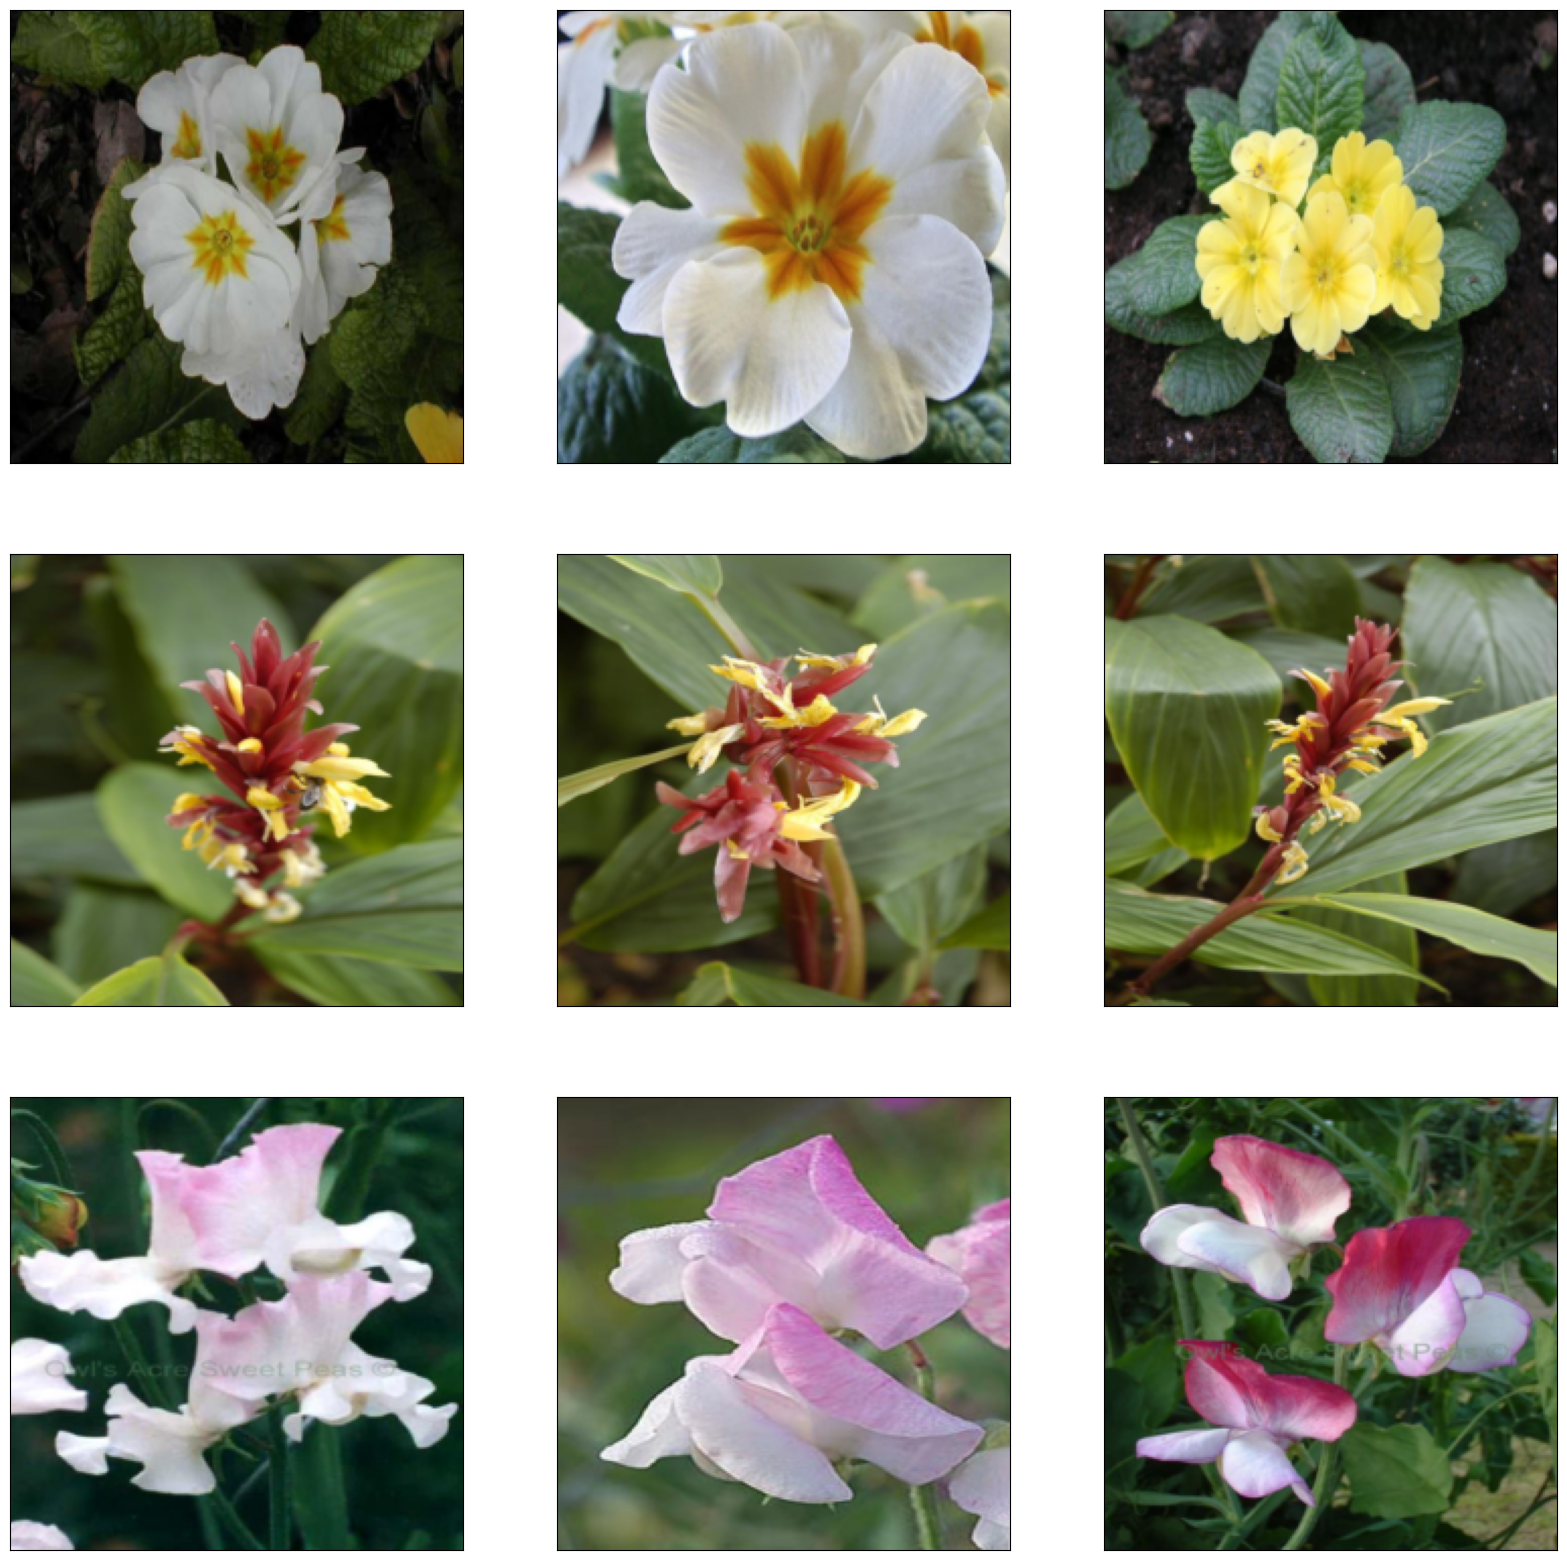

In [ ]:
_, axarr = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

sample_keys = list(train_loader.data.keys())

for a in range(3):
    for b in range(3):
      # Get some image sample to see if our dataloader works well: put same class images together
      temp_image = train_loader.data[sample_keys[a]][b]
      temp_image = temp_image.permute(1, 2, 0).numpy()

      # Clip the image values if necessary
      temp_image = np.clip(temp_image, 0, 1)  # Assuming the image is in the [0, 1] range

      axarr[a, b].imshow(temp_image)
      axarr[a, b].xaxis.set_visible(False)
      axarr[a, b].yaxis.set_visible(False)

plt.show()

Create an Siamese Network combined with our customized sim layer to calculate the similarity of the two input images.

In [ ]:
class SimilarityModel(nn.Module):
  def __init__(self):
    super(SimilarityModel, self).__init__()

    # Use the pre-trained ResNet model
    self.model = module

    # Create a sim layer to calculate the similarity score of these two input images(l2 distance)
    self.sim = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1000,256),
        nn.ReLU(),
        nn.Linear(256,1),
        nn.Sigmoid()
    )
  def forward(self, sample1, sample2):
    sample1_features = self.model(sample1)
    sample2_features = self.model(sample2)
    return self.sim(torch.abs(sample1_features - sample2_features))

In [ ]:
# Check if the loader works well
inputs,targets = train_loader.getBatch(16)
print(inputs[0].size())
print(targets)

torch.Size([16, 3, 224, 224])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])


<ipython-input-12-f43b153000b2>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  left[idx] = torch.tensor(random.sample(self.data[category], k=1)[0])
<ipython-input-12-f43b153000b2>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  right[idx] = torch.tensor(random.sample(self.data[category], k=1)[0])


In [ ]:
model = SimilarityModel()
model = model.to(device)

Test the untrained model, it returns about 0.5 for the similarity

In [ ]:
model(inputs[0].to(device), inputs[1].to(device))

tensor([[0.5792],
        [0.4411],
        [0.5536],
        [0.4952],
        [0.5012],
        [0.6830],
        [0.6031],
        [0.5482],
        [0.4611],
        [0.5098],
        [0.4842],
        [0.5514],
        [0.6157],
        [0.4567],
        [0.5379],
        [0.4979]], device='cuda:0', grad_fn=<SigmoidBackward0>)

# **Train the Siamese Network Model**

In [ ]:
model = model.train()
criteria = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
val_loader = SiameseLoader('./valid.txt')
all_labels = np.array([label for label in val_loader.data])

Define two predict methods for model validation, one is 102-way, 5-shot learning validation and the other is 5-way, 1-shot learning validation

In [ ]:
# Operate a 102-Way 5-shot few-shot learning first
def predict(image):
  sim_list = []
  with torch.no_grad():
    model.eval()
    for labels in all_labels:
      tensor_list = []
      for i in range(5):
        tensor_list.append(val_loader.data[labels][i])
      support_tensor = torch.stack(tensor_list)
      sim = model(image.repeat(5,1,1,1).to(device),support_tensor.to(device)).mean()
      #print('test')
      torch.cuda.empty_cache()
      sim_list.append(sim)

  result_index = torch.stack(sim_list).argmax().item()
  return all_labels[result_index]

In [ ]:
# Operate a 5-Way 1-shot few-shot learning
def predict_final(image, all_labels_N):
  sim_list = []
  #sample_keys = list(train_loader.data.keys())
  #all_labels_N = random.sample(all_labels, 5)
  with torch.no_grad():
    model.eval()
    for labels in all_labels_N:
      tensor_list = []
      i = random.randint(0, 9)
      tensor_list.append(val_loader.data[labels][i])
      support_tensor = torch.stack(tensor_list)
      sim = model(image.repeat(1,1,1,1).to(device),support_tensor.to(device))
      #print('test')
      torch.cuda.empty_cache()
      sim_list.append(sim)

  result_index = torch.stack(sim_list).argmax().item()
  return all_labels_N[result_index]
  #return result_index

Train the model using binary cross entropy(BCE) loss function and SGD optimizer with learning rate = 0.001. Train the model in 5000 epochs and set early stop = 500 epochs. Also save the best model with the least train loss.

In [ ]:
batch_size = 50
# Apply an early stop to stop the train process if the train loss still does not decrease for 500 epochs
early_stop = 500
min_loss = 100
last_epoch = 0
train_loss = []
val_acc = []
t_start = time.time()

print("------Start Training Process------")

for epoch in range(5000):
  inputs,targets = train_loader.getBatch(batch_size)
  outputs = model(inputs[0].to(device),inputs[1].to(device))
  loss = criteria(outputs.flatten(), targets.to(device).float())
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  train_loss.append(loss.item())

  if loss < min_loss:
    # Check the minimum loss and save the minimum model as the best model
    min_loss = loss.item()
    last_epoch = epoch
    torch.save(model, 'best_model.pt')

  if epoch - last_epoch > early_stop:
    break

  if epoch % 50 == 0:
    print(f"epoch {epoch}, loss {loss}")

    total = 0
    total_correct = 0

    for i in range(100):
      all_labels_N = random.sample(all_labels.tolist(), 5)
      label = random.sample(all_labels_N, 1)
      j  = random.randint(0, 9)
      image = val_loader.data[int(label[0])][j]
      predict_label = predict_final(image, all_labels_N)

      if predict_label == label[0]:
        total_correct += 1
    accuracy = total_correct/total
    val_acc.append(accuracy)

print("Finish Training.")
time_duration = (time.time() - t_start)/60
print(f"Time for training process: {time_duration} mins ")

------Start Training Process------


<ipython-input-12-f43b153000b2>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  left[idx] = torch.tensor(random.sample(self.data[category], k=1)[0])
<ipython-input-12-f43b153000b2>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  right[idx] = torch.tensor(random.sample(self.data[category], k=1)[0])


epoch 0, loss 0.708829939365387
epoch 50, loss 0.6211384534835815
epoch 100, loss 0.5654004812240601
epoch 150, loss 0.4338882267475128
epoch 200, loss 0.38914769887924194
epoch 250, loss 0.2945164144039154
epoch 300, loss 0.19986821711063385
epoch 350, loss 0.18758460879325867
epoch 400, loss 0.12242987006902695
epoch 450, loss 0.12177515029907227
epoch 500, loss 0.1163472905755043
epoch 550, loss 0.08196878433227539
epoch 600, loss 0.05883302539587021
epoch 650, loss 0.04500460624694824
epoch 700, loss 0.03317054361104965
epoch 750, loss 0.03547113388776779
epoch 800, loss 0.029592711478471756
epoch 850, loss 0.025805262848734856
epoch 900, loss 0.026504235342144966
epoch 950, loss 0.03522002696990967
epoch 1000, loss 0.019542483612895012
epoch 1050, loss 0.028085941448807716
epoch 1100, loss 0.01640225388109684
epoch 1150, loss 0.01549777016043663
epoch 1200, loss 0.014409850351512432
epoch 1250, loss 0.019007483497262
epoch 1300, loss 0.022792741656303406
epoch 1350, loss 0.0087648

# **Validate the Model**

Load the best model for validation

In [ ]:
model = torch.load('best_model.pt')
model = model.to(device)

In [ ]:
print(all_labels)

[ 29  60   6  11  84  93  54  48  21  85  51  24  33  31  56  83  74 100
  59  68  28  71  65  16   3  35  66   1  25  46  27  36  38  67   5  75
  39  92  52  30  50  78  72  88  73  76  69  15  91  90  77   4   8  45
  37  96  63  13  97  34  12  80   2  44  99  22  19  70  18  14  17  79
  95   0  43  82  89  87  58  10  41  40  53  61  49  64  62  94   7  23
  55  26   9 101  47  57  98  20  42  81  86  32]


The 102-Way, 5-shot learning validation accuracy is very low because the classes to be compared are too many. But it is already better then the small model we constructed before.

In [ ]:
total = 0
total_correct = 0
progress = tqdm(all_labels)

for labels in progress:
  for i in range(5, 10):
   image = val_loader.data[labels][i]
   predict_label = predict(image)

   total += 1
   if predict_label == labels:
    total_correct += 1
   progress.set_postfix({
      "accuracy": str("%.3f" % (total_correct/total))
   })

  0%|          | 0/102 [00:00<?, ?it/s]

In [ ]:
print("Accuracy:", total_correct / total)

In 5-Way 1-shot learning, the performance of this model is better. The accuracy is about 0.75

In [ ]:
total = 0
total_correct = 0
progress = tqdm(range(100))

for i in progress:
  all_labels_N = random.sample(all_labels.tolist(), 5)
  label = random.sample(all_labels_N, 1)
  j  = random.randint(0, 9)
  image = val_loader.data[int(label[0])][j]
  predict_label = predict_final(image, all_labels_N)

  if predict_label == label[0]:
    total_correct += 1
  progress.set_postfix({
    "accuracy": str("%.3f" % (total_correct/(i+1)))
  })

  0%|          | 0/100 [00:00<?, ?it/s]

# **Plot the Train Loss**

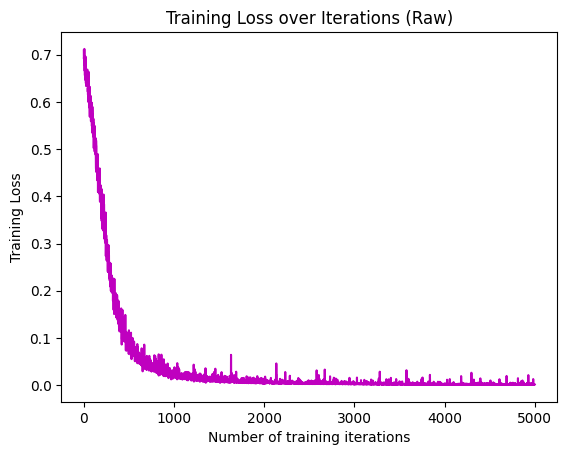

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(train_loss, "m", label="Training Loss")

plt.xlabel("Number of training iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss over Iterations (Raw)")

plt.show()

In [ ]:
window_width = 250

cumsum_vec = np.cumsum(np.insert(train_loss, 0, 0))
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

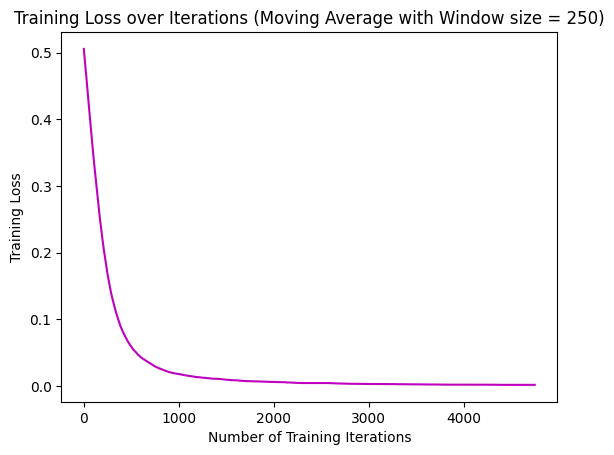

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ma_vec, "m", label="Training Loss (Moving Average)")

plt.xlabel("Number of Training Iterations")
plt.ylabel("Training Loss")
plt.title(f"Training Loss over Iterations (Moving Average with Window size = {window_width})")

plt.show()

# **A Simple Model at the Beginning**

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, input_shape):
        super(SiameseNet, self).__init__()
        self.module = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(102400, 4096),
            nn.ReLU(inplace=True),
        )
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.module(x)
        #x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return torch.sigmoid(self.out(torch.abs(output1 - output2)))

The simple model created by ourselves without pre-trained model acts poorly on validation, for 102-way, 1-shot learning, the accuracy is just 0.171, for the current model, the accuracy increases a lot.

In [1]:
total = 0
total_correct = 0

# random.shuffle(val_loader)
# progress = tqdm(val_loader)
progress = tqdm(all_labels)

for labels in progress:
  for i in range(5, 10):
   image = val_loader.data[labels][i]
   predict_label = predict(image)

   total += 1
   if predict_label == labels:
    total_correct += 1
   progress.set_postfix({
      "accuracy": str("%.3f" % (total_correct/total))
   })
print(total_correct/total)

0.171
